# Chest X-ray Dataset Exploration

In [27]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from rich import inspect
from tqdm import tqdm

# torch
import torch

# monai
import monai
from monai.data import ImageDataset, ThreadDataLoader

# sys path append
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [28]:
# rtk
from rtk import repl
from rtk.config import (
    set_hydra_configuration,
    Configuration,
    DatasetConfiguration,
    JobConfiguration,
)
from rtk.utils import login

In [29]:
repl.install(show_locals=False)
monai.config.print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/nicoleg/anaconda3/envs/ttk-env/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
ITK version: 5.3.0
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.33.3
mlflow version: 2.6.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

### Constant setup

In [30]:
# configs
config_name = "tests"
config_path = "../configs/"
config_dir = os.path.abspath(config_path)


In [31]:
cfg: Configuration = set_hydra_configuration(
        config_name=config_name,
        init_method_kwargs={"config_dir": config_dir},
        ConfigurationInstance=Configuration,
    )
dataset_cfg: DatasetConfiguration = cfg.datasets
job_cfg: JobConfiguration = cfg.job
monai.utils.set_determinism(seed=job_cfg.random_state)
cfg

[23:19:59] INFO     rtk.config: Creating configuration: 'tests'                                       ]8;id=6814;file:///home/nicoleg/workspaces/teddytoolkit/rtk/config.py\config.py]8;;\:]8;id=795667;file:///home/nicoleg/workspaces/teddytoolkit/rtk/config.py#285\285]8;;\
                    [0m                                                                                            


Configuration(
    index='',
    target='',
    date='2023-09-28',
    postfix='',
    timestamp='23-19-59',
    datasets={'extension': '.jpeg', 'labels': ['NORMAL', 'PNEUMONIA'], 'patient_data': None, 'scan_data': '/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/', 'encoding': {0: 'NORMAL', 1: 'PNEUMONIA'}, 'instantiate': {'_target_': 'monai.data.ImageDataset'}, 'dataloader': {'_target_': 'monai.data.DataLoader', 'batch_size': 4}, 'preprocessing': {'resample_value': 1, 'sample_to_value': -1, 'use_sampling': False}, 'transforms': {'load': [{'_target_': 'monai.transforms.ScaleIntensity'}, {'_target_': 'monai.transforms.EnsureChannelFirst'}, {'_target_': 'monai.transforms.EnsureType', 'track_meta': True}, {'_target_': 'monai.transforms.Resize', 'spatial_size': [224, 224]}], 'train': [{'_target_': 'torchvision.transforms.RandomResizedCrop', 'scale': [0.75, 1.25], 'size': [224, 224], 'antialias': True}, {'_target_': 'torchvision.transforms.RandomAffine', 'degrees': 45, '

In [32]:
scan_path = dataset_cfg.scan_data
scan_path

'/home/nicoleg/workspaces/teddytoolkit/.data/Chest_XRay_Images_RGB/'

In [33]:
# display single image
# depth_slice = scan.shape[2] // 2
# display_scan_slice = scan[:, :, depth_slice].numpy()
# plt.imshow(display_scan_slice, cmap="bone");

# Using `TTK`

In [34]:
from omegaconf import DictConfig
import logging

# rtk
from rtk import datasets
from rtk.utils import hydra_instantiate

logging.getLogger("rtk.datasets").setLevel(logging.DEBUG)

transform = datasets.create_transforms(
    cfg, use_transforms=job_cfg.use_transforms
)
dataset = datasets.instantiate_image_dataset(
    cfg=cfg, save_metadata=True, transform=transform
)
train_dataset, test_dataset = dataset[0], dataset[1]

[23:19:59] INFO     rtk.datasets: Creating transforms...                                             ]8;id=288389;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=256787;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#59\59]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Instantiating image dataset...                                    ]8;id=709570;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=776646;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#340\340]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'train'...     ]8;id=442417;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=33326;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#273\273]8;;\
                    [0m                                                                                            

           INFO     rtk.datasets: Building chest x-ray metadata dataframe for split: 'test'...      ]8;id=529903;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py\datasets.py]8;;\:]8;id=631262;file:///home/nicoleg/workspaces/teddytoolkit/rtk/datasets.py#273\273]8;;\
                    [0m                                                                                            

In [35]:
transform.transforms


(
    RandomResizedCrop(size=[224, 224], scale=(0.75, 1.25), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True),
    RandomAffine(degrees=[-45.0, 45.0], translate=[0.15, 0.2], shear=[-16.0, 16.0]),
)

In [36]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [37]:
train_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=train_dataset,
    pin_memory=torch.cuda.is_available(),
    shuffle=True,
)
test_loader = hydra_instantiate(
    cfg=dataset_cfg.dataloader,
    dataset=test_dataset,
    pin_memory=torch.cuda.is_available(),
)
iterator = iter(train_loader)


## Get some samples

In [54]:
scan, label = next(iterator)
scan.shape, label

(torch.Size([4, 3, 224, 224]), tensor([0, 0, 0, 1]))

In [55]:
_filename = scan[0]._meta['filename_or_obj'].split('/')[-1]
patient_id = _filename.split('.')[0]
patient_id

'NORMAL-5791834-0001'

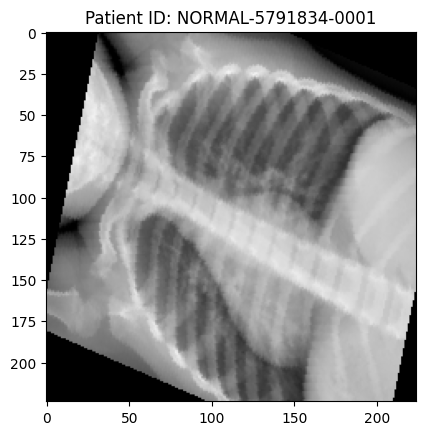

In [56]:
plt.title(f"Patient ID: {patient_id}")
display_scan = scan[0].numpy()
display_scan = np.transpose(display_scan, (1, 2, 0))
plt.imshow(display_scan, cmap="bone");

In [57]:
display_scan


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)